https://www.kaggle.com/datasets/zhiruo19/covid19-symptoms-classification

In [53]:
import warnings  
from pathlib import Path  

import matplotlib.pyplot as plt  
%matplotlib inline
import numpy as np  
import pandas as pd  
import scipy as sp  
import seaborn as sns  

from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning, FitFailedWarning
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
df = pd.read_csv('/content/data.csv')
df.head()

,fever,bodypain,age,runnynose,diffbreath,infected
0,99.329862,0,26,1,-1,0
1,98.115263,1,61,1,0,1
2,99.918088,1,13,0,-1,0
3,101.344456,1,55,1,0,1
4,100.056678,1,37,0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fever       1999 non-null   float64
 1   bodypain    1999 non-null   int64  
 2   age         1999 non-null   int64  
 3   runnynose   1999 non-null   int64  
 4   diffbreath  1999 non-null   int64  
 5   infected    1999 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 93.8 KB


In [7]:
def apply(s: pd.Series):
    convert = [pd.to_numeric(x, errors='ignore') for x in s]
    numeric = [x for x in convert if not isinstance(x, str)]
    strings = [x for x in convert if isinstance(x, str)]
    return f'n: {len(s)}, num: {len(numeric)}, str: {len(strings)}, {set(strings)}'

problem_cols = ['fever', 'age']
df[problem_cols].apply(apply)

fever    n: 1999, num: 1999, str: 0, set()
age      n: 1999, num: 1999, str: 0, set()
dtype: object

In [8]:
df[problem_cols] = df[problem_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df[problem_cols].dtypes

fever    float64
age        int64
dtype: object

In [9]:
df.describe()

,fever,bodypain,age,runnynose,diffbreath,infected
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,100.512027,0.488244,47.331666,0.499250,-0.024012,0.503752
std,1.438389,0.499987,20.467449,0.500125,0.816143,0.500111
min,98.005787,0.000000,12.000000,0.000000,-1.000000,0.000000
25%,99.255045,0.000000,30.000000,0.000000,-1.000000,0.000000
50%,100.521666,0.000000,48.000000,0.000000,0.000000,1.000000
75%,101.728421,1.000000,65.000000,1.000000,1.000000,1.000000
max,102.995724,1.000000,82.000000,1.000000,1.000000,1.000000


In [10]:
categorical_cols = df.columns[df.dtypes == object]

df[categorical_cols].apply(lambda s: s.unique())

Series([], dtype: float64)

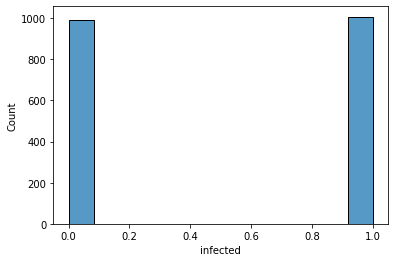

In [13]:
df[categorical_cols] = df[categorical_cols].apply(lambda s: s.str.strip())
df[categorical_cols].apply(lambda s: s.unique())
sns.histplot(x=df['infected']);

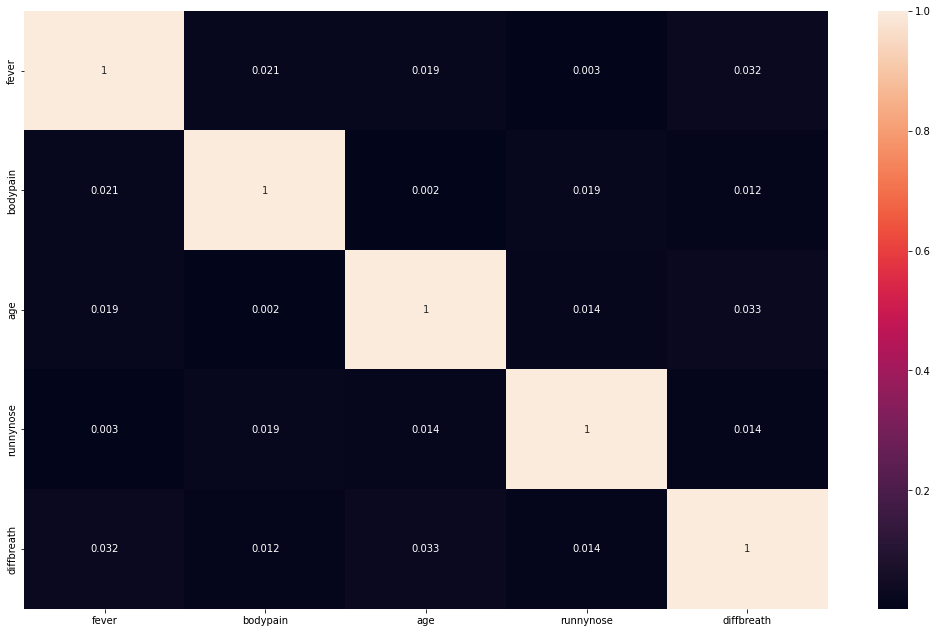

In [57]:
corr_abs = df[df.columns[:-1]].corr().abs()
_, ax = plt.subplots(figsize=(18, 11))
sns.heatmap(corr_abs, ax=ax, cbar=True, annot=True);

In [15]:
threshold = 0.9
cnt = pd.notna(corr_abs[corr_abs > threshold]).sum()
cnt[cnt > 1]

Series([], dtype: int64)

In [17]:
cnt = df.isna().sum()
cnt[cnt > 0].sort_values(ascending=False) # Пропусков у нас нет, что очень круто

Series([], dtype: int64)


In [45]:
mode_cols = list({'age', *df.columns[df.dtypes == object]} - {'infected'})
mode = df[mode_cols].mode().squeeze(axis=0)
df[mode_cols] = df[mode_cols].fillna(mode)
mode

age    38
Name: 0, dtype: int64

In [20]:
mean_cols = ['fever', 'age']
mean = df[mean_cols].mean()
df[mean_cols] = df[mean_cols].fillna(mean)
mean #Смотрим среднее по столбцам

fever    100.512027
age       47.331666
dtype: float64

In [25]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
estimator = Pipeline([
    ('clf', LogisticRegression())
])

In [27]:
estimate_param_grid = [{
    'clf': [
        LogisticRegression(random_state=0),
        KNeighborsClassifier(),
        SVC(random_state=0),
        LinearSVC(random_state=0),
        PassiveAggressiveClassifier(random_state=0),
        RandomForestClassifier(random_state=0),
        ExtraTreesClassifier(random_state=0),
        RidgeClassifier(random_state=0),
        MLPClassifier(random_state=0),
        SGDClassifier(loss='hinge', random_state=0),  
        SGDClassifier(loss='log_loss', random_state=0), 
        SGDClassifier(loss='modified_huber', random_state=0),  
        SGDClassifier(loss='squared_hinge', random_state=0),  
        SGDClassifier(loss='perceptron', random_state=0),  
    ]
}]

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted' ] # выбираем признаки, по которым мы будет обучать модель

grid_search = GridSearchCV(
    estimator,
    estimate_param_grid,
    scoring=scoring,
    refit='f1_weighted',
    cv=3,
    verbose=4,
    n_jobs=4,
)

In [33]:
with warnings.catch_warnings():
  warnings.simplefilter('ignore', category=ConvergenceWarning)
  warnings.simplefilter('ignore', category=UndefinedMetricWarning)
  warnings.simplefilter('ignore', category=FitFailedWarning)
  grid_search.fit(X_train, y_train) # почему-то пишет, что у нас есть nan, хотя таковых не имеется. Возможно, это ошибка

Fitting 3 folds for each of 14 candidates, totalling 42 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.50719199 0.49155722 0.50781739 0.50281426 0.49280801 0.5134459
 0.51031895 0.50969356 0.52282677 0.50218887        nan 0.50093809
 0.50281426 0.49718574]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.50626743 0.49158558 0.42312608 0.25286677 0.24286051 0.51322843
 0.51005382 0.50896913 0.43965798 0.33206975        nan 0.3355625
 0.25286677 0.24723825]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.50247085 0.49156612 0.44316028 0.33649132 0.3253735  0.51253633
 0.50951984 0.50542307 0.46526058 0.3508339         nan 0.38495049
 0.33649132 0.33023757]
  category=UserWarning,


In [34]:
keys = [
    'params',
    'mean_test_f1_weighted',
    'mean_fit_time',
    'mean_score_time',
    'mean_test_accuracy',
    'mean_test_precision_weighted',
    'mean_test_recall_weighted',
] # расставляем все значения. Они понадобятся нам в будущем при анализе

report = pd.DataFrame(grid_search.cv_results_)[keys]
report['params'] = report['params'].apply(lambda x: str(x['clf']).replace('random_state=0', ''))
report = report.rename(columns=lambda x: x.replace('_test', '').replace('_weighted', '').replace('mean_', ''))

In [35]:
report.sort_values('f1', ascending=False)

,params,f1,fit_time,score_time,accuracy,precision,recall
5,RandomForestClassifier(),0.512536,0.839923,0.094787,0.513446,0.513228,0.513446
6,ExtraTreesClassifier(),0.509520,0.671288,0.102254,0.510319,0.510054,0.510319
7,RidgeClassifier(),0.505423,0.014417,0.023159,0.509694,0.508969,0.509694
0,LogisticRegression(),0.502471,0.037622,0.013973,0.507192,0.506267,0.507192
1,KNeighborsClassifier(),0.491566,0.012149,0.105086,0.491557,0.491586,0.491557
8,MLPClassifier(),0.465261,0.552374,0.019036,0.522827,0.439658,0.522827
2,SVC(),0.443160,0.240164,0.173259,0.507817,0.423126,0.507817
11,"SGDClassifier(loss='modified_huber', )",0.384950,0.027509,0.028449,0.500938,0.335563,0.500938
9,SGDClassifier(),0.350834,0.034353,0.020052,0.502189,0.332070,0.502189
3,LinearSVC(),0.336491,0.118141,0.019223,0.502814,0.252867,0.502814


как мы видим, sgdclassifier получил очень много Nan, что явно показывает, что данная модель плоха в обучении

In [39]:
%%time

clf = ExtraTreesClassifier(random_state=0)
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

CPU times: user 420 ms, sys: 830 µs, total: 421 ms
Wall time: 664 ms


In [40]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.54      0.50       181
           1       0.57      0.50      0.53       219

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.52      0.52      0.52       400



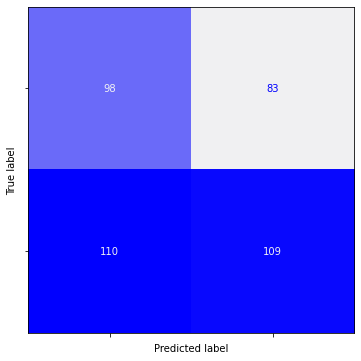

In [49]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=enc.categories_[:-1],
    colorbar=False,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(6, 6)

Text(0.5, 1.0, 'Predicted vs True values')

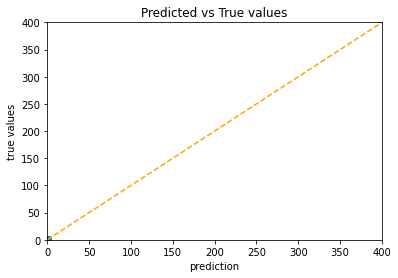

In [56]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(0,400,400), np.linspace(0,400,400), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0,400)
plt.ylim(0,400)
plt.title('Predicted vs True values') 

Как мы видим, данные, которые мы предсказываем, совпадают с тем, что является истиными значениями

In [54]:
model = RandomForestRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1, random_state=0, n_estimators=100)

model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred))) #Все очень плохо... Если R2 такой низкий это может говорить лишь о том, что данная модель плоха в обучении данного датасета

RMSE: 0.5008843112538028
MAE: 0.4999711425240584
R-squared: -0.012679808310790852
